# Notebook for working with root files from DDSIM to look at hcalbarrelhits and MCParticles

In [121]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm


Open the root file with up.open, then save a branch to a np array using the .array() method

In [166]:
particle = "pi"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}

uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_12/One_sector/{particle}_{energy}GeV_5k.edm4hep.root:events"
events = up.open(uproot_path)

x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
Pathlength_branch = events["HcalBarrelHits.pathLength"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
MC_parents = events["_MCParticles_parents.index"].array(library='np')
MC_daughters = events["MCParticles.daughters_end"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
MC_endpoint_x_branch = events["MCParticles.endpoint.x"].array(library='np')
layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]    

This function gets the layer index from the position - the layer map is a list of the midpoints of each layer, and each layer is 1cm thick, so we can 
check if hits hit within 0.5cm on each side of the midpoint to check which layer they hit

In [162]:
def get_num_layers_traversed(x_pos):
    #This map contains the midpoints of each layer - each layer is 1cm in width, so we can check the 0.5cm on each side to see if a hit was in the layer
    layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]
    for layer_idx in range(len(layer_map)):
        #check if particle hit within layer
        if ((x_pos >= layer_map[layer_idx] - 5) and (x_pos <= layer_map[layer_idx] + 5)):
            return layer_idx
    #if no layers hit, send error code
    return -1

In [163]:
min_energy_dep_for_photon = (0.1 / 1000 / 1000) / 0.005

In [164]:
energy_dep_event = []
energy_dep_event_primary = []
no_hits_in_event = 0
no_primary_hits = 0
under_min = 0
total_hits = 0
for event_idx in range(len(EDep_branch)):
    energy_dep = 0
    energy_dep_primary = 0
    if(len(EDep_branch[event_idx]) == 0):
        no_hits_in_event += 1
    if(0 not in Hits_MC_idx_branch[event_idx]):
        no_primary_hits += 1
    for i in range(len(EDep_branch[event_idx])):
#         if((get_num_layers_traversed(x_pos_branch[event_idx][i]) != 1) and (get_num_layers_traversed(x_pos_branch[event_idx][i]) != 0)):
#             continue
        energy_dep += EDep_branch[event_idx][i]
        total_hits += 1
        if(Hits_MC_idx_branch[event_idx][i] == 0):
            energy_dep_primary += EDep_branch[event_idx][i]
    energy_dep_event.append(energy_dep)
    energy_dep_event_primary.append(energy_dep_primary)
print(f"avg energy dep: {sum(energy_dep_event) / len(energy_dep_event)} | avg energy dep from primary: {sum(energy_dep_event_primary) / len(energy_dep_event_primary)} | no_primary_hits frac: {no_primary_hits / len(EDep_branch)} | no_hits_in_event {no_hits_in_event}")

avg energy dep: 0.2581811297550176 | avg energy dep from primary: 0.008977748388044028 | no_primary_hits frac: 0.2686 | no_hits_in_event 0


total: mean: 258.1811297550176 | sigma: 75.34566107278862 | primary: mean: 8.977748388044029 | sigma: 10.284516578723213


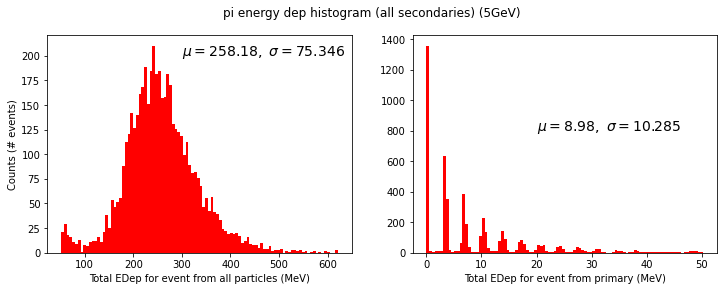

In [186]:
energy_dep_event_MeV = []
energy_dep_event_primary_MeV = []
for i in range(len(energy_dep_event)):
    energy_dep_event_MeV.append(energy_dep_event[i] * 1000)
    energy_dep_event_primary_MeV.append(energy_dep_event_primary[i] * 1000)
(mu, sigma) = norm.fit(energy_dep_event_MeV)
(mu_primary, sigma_primary) = norm.fit(energy_dep_event_primary_MeV)

fig, (ax1,ax2) = plot.subplots(1,2, figsize=(12,4))
ax1.hist(energy_dep_event_MeV,bins= 100,color = color_dict[particle]);
ax1.set_xlabel("Total EDep for event from all particles (MeV)")
ax1.set_ylabel("Counts (# events)")
ax1.text(300,200,r'$\mu=%4.2f,\ \sigma=%4.3f$'%(mu,sigma),fontsize=14)

ax2.hist(energy_dep_event_primary_MeV,bins= 100, color = color_dict[particle]);
ax2.set_xlabel("Total EDep for event from primary (MeV)")
ax2.text(20,800,r'$\mu=%4.2f,\ \sigma=%4.3f$'%(mu_primary,sigma_primary),fontsize=14)
print(f"total: mean: {mu} | sigma: {sigma} | primary: mean: {mu_primary} | sigma: {sigma_primary}")
fig.suptitle(f"{particle} energy dep histogram (all secondaries) ({energy}GeV)")
fig.show()
# fig.savefig(f"plots/June_12/one_sector/all_layers_energy_dep_{particle}_{energy}GeV.jpeg")

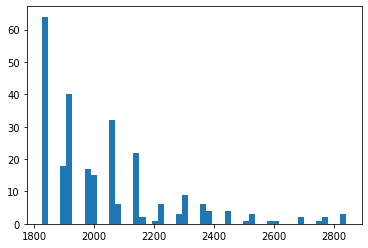

In [185]:
layer_num = []
endpoint_x = []
for i in range(len(MC_endpoint_x_branch)):
    event_pion_dep = 0
    curr_layer = get_num_layers_traversed(MC_endpoint_x_branch[i][0])
    if(curr_layer == -1):
        continue
    layer_num.append(np.floor(get_num_layers_traversed(MC_endpoint_x_branch[i][0]) // 2))
    endpoint_x.append(MC_endpoint_x_branch[i][0])
# plot.hist(pion_dep,bins = 100);
plot.hist(endpoint_x,bins = 50);

In [183]:
len(MC_endpoint_x_branch)

5000

## Percentage of photons hitting sensor

In [86]:
num_MC = 0
num_hits = 0
energy_dep = 0
dep_count = 0
hits_per_photon = []
for event_idx in range(len(EDep_branch)):
    for i in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][i] == -22 and (i < MC_daughters[event_idx][0])):num_MC+= 1
    for i in range(len(EDep_branch[event_idx])):
        num_hits += 1
    hits_per_photon.append(num_hits / num_MC)
print(f"% of photons hitting = {sum(hits_per_photon) / len(hits_per_photon) * 100}%")

% of photons hitting = 0.46485284140641503%


mean: 0.46485284140641464 | sigma: 0.006195818634333814


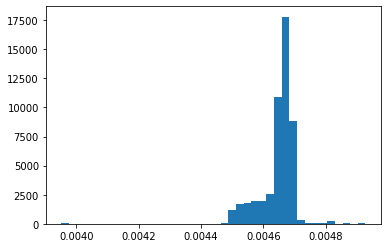

In [62]:
plot.hist(hits_per_photon * 100,bins = 40);
(mu, sigma) = norm.fit(hits_per_photon)
print(f"mean: {mu * 100} | sigma: {sigma * 100}")

## Energy deposited by mu/pi | # of photons per KeV deposited


In [35]:
energy_dep_event = []
num_per_kev = []
skipped_events = 0
for event_idx in range(1000):
    num_MC = 0
    num_hits = 0
    dep_count = 0
    energy_dep = 0
    for i in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][i] == -22 and (i < MC_daughters[event_idx][0])):num_MC+= 1 #count # of optph from muon
    for i in range(len(EDep_branch[event_idx])):
#         if(Hits_MC_idx_branch[event_idx][i] == 0):
        if(True):
            energy_dep += EDep_branch[event_idx][i]
            dep_count += 1
    energy_dep_event.append(energy_dep)
    if(energy_dep == 0):
        skipped_events += 1
        continue
    num_per_kev.append(num_MC / (energy_dep * 1000 * 1000))
print(f"# photons per KeV = {sum(num_per_kev) / len(num_per_kev)} | avg energy dep: {sum(energy_dep_event) / len(energy_dep_event)} | skipped {skipped_events} events")

fig, ax = plot.subplots(1,1)
ax.hist(energy_dep_event,bins= 50);
(mu, sigma) = norm.fit(energy_dep_event)
print(f"mean: {mu} | sigma: {sigma}")
fig.suptitle("pi energy dep histogram (all secondaries) (5GeV)")
fig.show()
fig.savefig("plots/June_12/energy_dep_pi_all_secondaries.jpeg")

In [ ]:
parent_list = []
for i in range(len(MC_parents[0])):
    if (MC_parents[0][i] not in parent_list):
        parent_list.append(MC_parents[0][i])
for i in range(len(parent_list)):
    print(PDG_branch[0][parent_list[i]])

Plot energy deposition

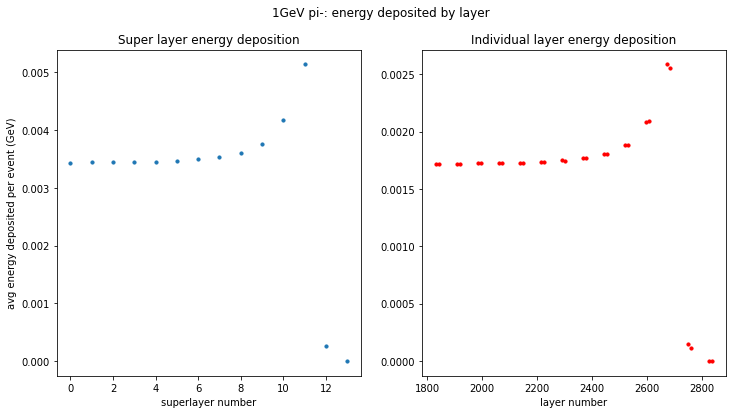

In [78]:
fig,(ax1,ax2) = plot.subplots(1,2,figsize=(12,6))
fig.suptitle("1GeV pi-: energy deposited by layer")
ax1.set_title("Super layer energy deposition")
ax2.set_title("Individual layer energy deposition")

ax1.set_xlabel("superlayer number")
ax2.set_xlabel("layer number")

ax1.set_ylabel("avg energy deposited per event (GeV)")
ax1.scatter(range(14),super_layer_EDep,10)
ax2.scatter(layer_map,layer_EDep,10,color = 'r',marker='o')
fig.show()
# fig.savefig("plots/energy_dep/mu_1GeV_10k_edep_vs_layer_num.jpeg")